In [2]:
# ==============================================================================
# Step 1: Initialize Session & Analyze Metadata (Path Fixed)
# ==============================================================================
import sys
import os
from pathlib import Path

# 🔧 自动修复路径：尝试将项目根目录添加到系统路径
current_path = Path.cwd()
project_root = None

# 向上查找包含 src 的目录
if (current_path / "src").exists():
    project_root = current_path
elif (current_path.parent / "src").exists():
    project_root = current_path.parent
    sys.path.append(str(project_root))
    print(f"✅ 已将项目根目录添加到路径: {project_root}")

# 再次检查
try:
    from src.session import DataSession
    from src.utils import enable_polars_markdown_display
    import polars as pl
    print("✅ 成功导入 src 模块")
except ImportError:
    print("❌ 仍然无法找到 'src' 模块。请确保：")
    print("1. 你已创建了 'src' 文件夹")
    print("2. 'src' 文件夹内包含 '__init__.py', 'session.py', 'utils.py' 等文件")
    # 如果是在完全没有文件的环境中，这里会停止
    raise

# ------------------------------------------------------------------------------
# 以下是分析逻辑
# ------------------------------------------------------------------------------

# 1. 启用 Markdown 表格输出规范
enable_polars_markdown_display()

# 2. 加载数据会话
dataset_id = "insurance_data_cleaned" 
session = DataSession()

# 检查数据是否已存在，不存在则加载
# ⚠️ 如果你没有 alldata 数据集，请确保在这里加载正确的文件，例如 session.load("data.csv")
if f"df_{dataset_id}" not in locals():
    # 为了演示，如果你没有真实数据，这里可能会报错。
    # 如果已有 df_df 变量，可以直接注释掉下面这行
    try:
        session.load(dataset_id, alias="df")
    except Exception as e:
        print(f"ℹ️ 提示: 加载默认数据失败 ({e})") 
        print("   如果你已经手动加载了 dataframe (例如 df = pl.read_csv...)，请忽略此提示。")
else:
    print(f"✅ 数据 {dataset_id} 已在会话中")

# 获取全局数据对象 (尝试获取 df_df，如果不存在则使用 session 中的第一个)
try:
    df_target = df_df
except NameError:
    if session.list_loaded():
        first_key = session.list_loaded()[0]
        df_target = session.get(first_key)
        print(f"⚠️ 使用已加载的第一个数据集: {first_key}")
    else:
        print("❌ 错误: 会话中没有数据。请先加载数据 (例如: session.load('your_file.csv'))")
        raise ValueError("No data loaded")

# 3. 自动化维度/度量识别逻辑
print("\n## 🔍 数据结构自动化分析报告\n")

suggested_dimensions = []
suggested_metrics = []

for col in df_target.columns:
    # 获取元数据
    dtype = str(df_target[col].dtype)
    n_unique = df_target[col].n_unique()
    
    # A. 识别潜在维度 (String 或 Date)
    if dtype == 'String' or dtype.startswith('Date') or dtype == 'Boolean':
        dim_info = {
            'name': col,
            'type': dtype,
            'unique_values': n_unique,
            'recommendation': ''
        }
        
        if n_unique <= 10:
            dim_info['recommendation'] = "Dropdown (单选/全选)"
        elif n_unique <= 50:
            dim_info['recommendation'] = "MultiChoice (多选)"
        elif n_unique <= 500:
            dim_info['recommendation'] = "MultiChoice (带搜索)"
        else:
            dim_info['recommendation'] = "⚠️ 建议作为级联子级或不作为主维度"
            
        suggested_dimensions.append(dim_info)
        
    # B. 识别潜在度量 (Numeric)
    elif dtype in ['Float64', 'Int64', 'Int32', 'Float32']:
        suggested_metrics.append(f"- **{col}** ({dtype})")

# 4. 输出建议供用户确认
print("### ✅ 建议的分析维度 (Dimensions):\n")
print("| 字段名 | 类型 | 唯一值数量 | 建议控件 |")
print("|---|---|---|---|")
for dim in suggested_dimensions:
    print(f"| **{dim['name']}** | {dim['type']} | {dim['unique_values']} | {dim['recommendation']} |")

print("\n### 🔢 建议的度量指标 (Metrics):\n")
for met in suggested_metrics:
    print(met)

print("\n" + "="*80)
print("💡 下一步：请查看上表，并回复确认使用的维度列表 ANALYSIS_DIMENSIONS。")
print("="*80)

✅ 已将项目根目录添加到路径: /Users/harold/working/Jupyter_AI_DataAnalyze
✅ 成功导入 src 模块
✅ Polars Markdown 显示已启用
💡 现在所有 DataFrame 将以表格格式自动显示
✅ 已加载: df_df (insurance_data_cleaned)

## 🔍 数据结构自动化分析报告

### ✅ 建议的分析维度 (Dimensions):

| 字段名 | 类型 | 唯一值数量 | 建议控件 |
|---|---|---|---|
| **业务年度** | String | 25 | MultiChoice (多选) |
| **机构代码** | String | 1112 | ⚠️ 建议作为级联子级或不作为主维度 |
| **机构名称** | String | 1109 | ⚠️ 建议作为级联子级或不作为主维度 |
| **业务险种** | String | 26 | MultiChoice (多选) |
| **保单号** | String | 662206 | ⚠️ 建议作为级联子级或不作为主维度 |
| **危险单位号** | String | 830 | ⚠️ 建议作为级联子级或不作为主维度 |
| **支付币别** | String | 3 | Dropdown (单选/全选) |
| **业务来源** | String | 28 | MultiChoice (多选) |
| **是否联共保** | String | 5 | Dropdown (单选/全选) |
| **地址代码** | String | 402718 | ⚠️ 建议作为级联子级或不作为主维度 |
| **标的地址或船名** | String | 399060 | ⚠️ 建议作为级联子级或不作为主维度 |
| **被保险人名称** | String | 230669 | ⚠️ 建议作为级联子级或不作为主维度 |
| **保险起期** | String | 8480 | ⚠️ 建议作为级联子级或不作为主维度 |
| **保险止期** | String | 9602 | ⚠️ 建议作为级联子级或不作为主维度 |
| **风险代码** | String | 1828 | ⚠️ 建议作为级联子级或不作为主维度 |


✅ 分析年份区间: ['2021年', '2022年', '2023年', '2024年', '2025年']


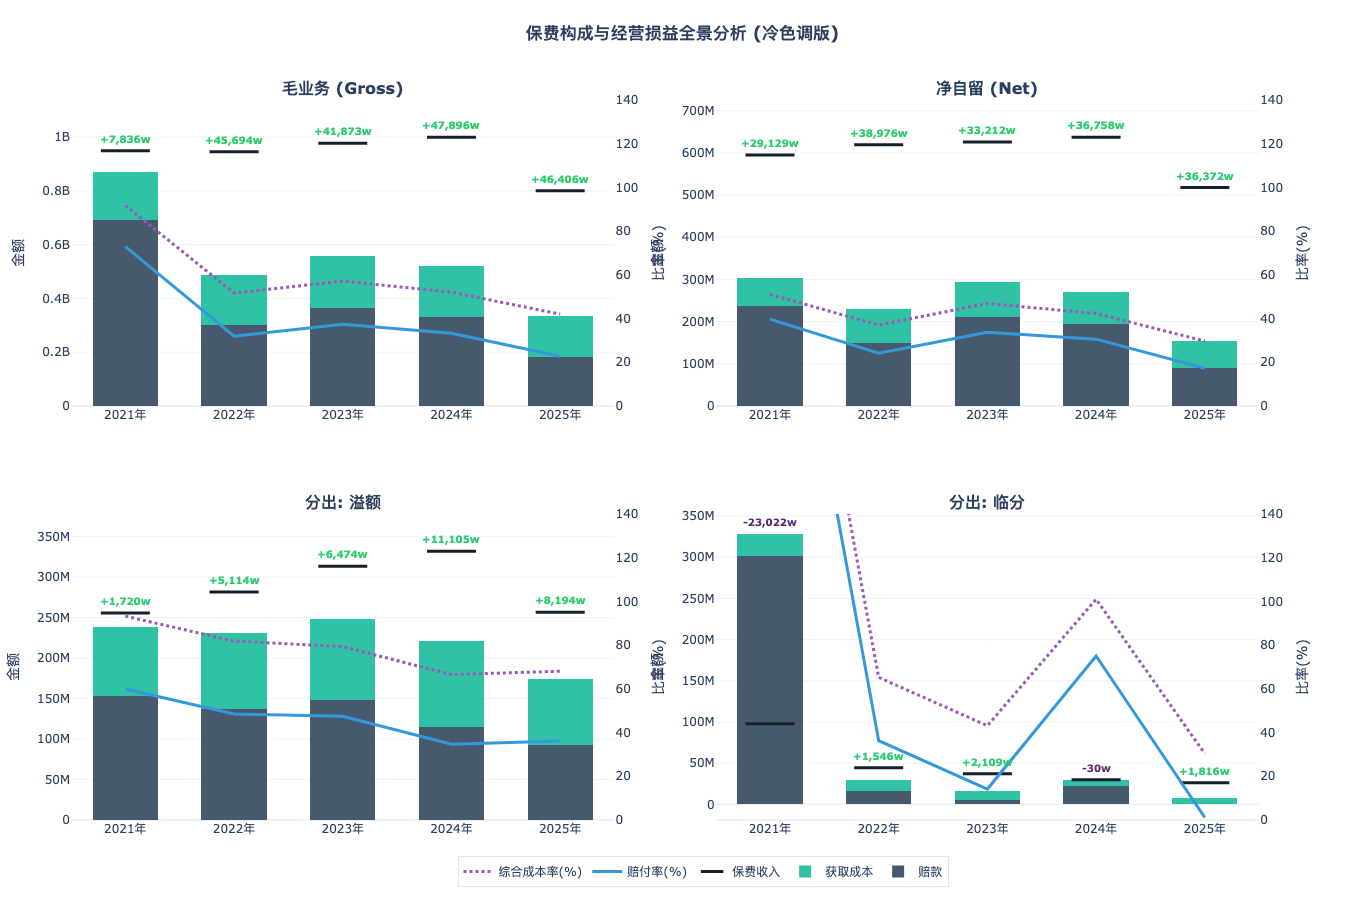

In [18]:
import polars as pl
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ==============================================================================
# 1. 数据准备 (保持核弹级修复逻辑)
# ==============================================================================
if 'df_df' in locals():
    df_raw = df_df.clone()
    
    # 强制加上 "年" 字，物理隔绝 Plotly 的数字误判
    df_clean = df_raw.with_columns(
        (pl.col('业务年度').cast(pl.Utf8) + "年").alias('Year_Label')
    )
    
    # 填充空值
    numeric_cols = [col for col in df_clean.columns if df_clean[col].dtype in [pl.Float64, pl.Int64]]
    df_clean = df_clean.with_columns([pl.col(c).fill_null(0) for c in numeric_cols])
    
    # 锁定最近5年
    top_years = df_clean['Year_Label'].unique().sort(descending=True).head(5).to_list()
    top_years_sorted = sorted(top_years)
    
    df_viz = df_clean.filter(pl.col('Year_Label').is_in(top_years))
    print(f"✅ 分析年份区间: {top_years_sorted}")
else:
    print("❌ 错误：请先加载数据")
    df_viz = pl.DataFrame()

# ==============================================================================
# 2. 指标聚合
# ==============================================================================
plot_data = {}
active_ced_types = ['溢额', '临分']
all_ced_types = ['协议', '成数', '溢额', 'OPENCOVER', '临分']

# 预计算摊回费用
avail_ced = [f'{t}摊回费用' for t in all_ced_types if f'{t}摊回费用' in df_viz.columns]
total_comm_rec_expr = sum([pl.col(c) for c in avail_ced]) if avail_ced else pl.lit(0)

# 毛业务费用
gross_fee_expr = pl.lit(0)
for c in ['手续费', '分入手续费', '分入出单费', '分入经纪费']:
    if c in df_viz.columns: gross_fee_expr = gross_fee_expr + pl.col(c)

# A. 毛业务
plot_data['毛业务(Gross)'] = df_viz.group_by('Year_Label').agg([
    pl.col('总保费').sum().alias('Premium'),
    (pl.col('总已决赔款') + pl.col('总未决赔款')).sum().alias('Loss'),
    gross_fee_expr.sum().alias('Cost')
]).sort('Year_Label')

# B. 净业务
plot_data['净自留(Net)'] = df_viz.group_by('Year_Label').agg([
    (pl.col('自留保费') + pl.col('附加自留保费')).sum().alias('Premium'),
    (pl.col('自留已决') + pl.col('自留未决') + pl.col('附加自留已决') + pl.col('附加自留未决')).sum().alias('Loss'),
    (gross_fee_expr - total_comm_rec_expr).sum().alias('Cost')
]).sort('Year_Label')

# C. 分出业务
for t in active_ced_types:
    if f'{t}分保费' in df_viz.columns:
        plot_data[f'分出-{t}'] = df_viz.group_by('Year_Label').agg([
            pl.col(f'{t}分保费').sum().alias('Premium'),
            (pl.col(f'{t}已决') + pl.col(f'{t}未决')).sum().alias('Loss'),
            pl.col(f'{t}摊回费用').sum().alias('Cost')
        ]).sort('Year_Label')

# ==============================================================================
# 3. 绘图 (Cool Tone & Clean Lines)
# ==============================================================================
titles = ['<b>毛业务 (Gross)</b>', '<b>净自留 (Net)</b>'] + [f'<b>分出: {t}</b>' for t in active_ced_types]

# 🎨 冷色调配色方案 (Cool Tone Palette)
c_prem = '#17202A'  # 午夜蓝 (接近黑，基准线)
c_loss = '#34495E'  # 深蓝灰 (赔款 - 替代原本的红色)
c_cost = '#1ABC9C'  # 水绿色 (成本 - 替代原本的黄色)
c_lr   = '#3498DB'  # 亮海蓝 (赔付率线)
c_cor  = '#9B59B6'  # 紫罗兰 (综成率线)
c_prof = '#2ECC71'  # 青草绿 (盈利文字)
c_neg  = '#5B2C6F'  # 深紫色 (亏损文字 - 替代原本的红色)

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=titles,
    shared_xaxes=False,
    vertical_spacing=0.15, horizontal_spacing=0.08,
    specs=[[{"secondary_y": True}, {"secondary_y": True}],
           [{"secondary_y": True}, {"secondary_y": True}]]
)

positions = [
    (1, 1, '毛业务(Gross)'), (1, 2, '净自留(Net)'),
    (2, 1, '分出-溢额'),    (2, 2, '分出-临分')
]

for row, col, key in positions:
    if key not in plot_data: continue
    
    df_curr = plot_data[key]
    x_labels = df_curr['Year_Label'].to_list()
    v_prem = df_curr['Premium'].to_list()
    v_loss = df_curr['Loss'].to_list()
    v_cost = df_curr['Cost'].to_list()
    
    # 计算比率
    v_lr = [(l/p*100 if p!=0 else 0) for l, p in zip(v_loss, v_prem)]
    v_cor = [((l+c)/p*100 if p!=0 else 0) for l, c, p in zip(v_loss, v_cost, v_prem)]
    
    # --- 左轴：堆叠柱状图 ---
    
    # 1. 赔款 (底层)
    fig.add_trace(go.Bar(
        x=x_labels, y=v_loss, name='赔款', 
        marker_color=c_loss, opacity=0.9, marker_line_width=0,
        showlegend=(key=='毛业务(Gross)'),
        hovertemplate='赔款: %{y:,.0f}'
    ), row=row, col=col, secondary_y=False)
    
    # 2. 费用 (上层)
    fig.add_trace(go.Bar(
        x=x_labels, y=v_cost, name='获取成本', 
        marker_color=c_cost, opacity=0.9, marker_line_width=0,
        showlegend=(key=='毛业务(Gross)'),
        hovertemplate='成本: %{y:,.0f}'
    ), row=row, col=col, secondary_y=False)
    
    # 3. 保费 (封顶线) - 保持 Marker 以显示横杠
    fig.add_trace(go.Scatter(
        x=x_labels, y=v_prem, name='保费收入',
        mode='markers', 
        marker=dict(symbol='line-ew', size=35, line=dict(width=3, color=c_prem)),
        showlegend=(key=='毛业务(Gross)'),
        hovertemplate='保费: %{y:,.0f}'
    ), row=row, col=col, secondary_y=False)
    
    # --- 右轴：纯净折线图 (无点) ---
    
    # 4. 赔付率 (LR)
    fig.add_trace(go.Scatter(
        x=x_labels, y=v_lr, name='赔付率(%)',
        mode='lines', # ✨ 仅显示线条，不显示点
        line=dict(color=c_lr, width=3),
        showlegend=(key=='毛业务(Gross)'),
        hovertemplate='LR: %{y:.1f}%'
    ), row=row, col=col, secondary_y=True)
    
    # 5. 综合成本率 (COR)
    fig.add_trace(go.Scatter(
        x=x_labels, y=v_cor, name='综合成本率(%)',
        mode='lines', # ✨ 仅显示线条，不显示点
        line=dict(color=c_cor, width=3, dash='dot'),
        showlegend=(key=='毛业务(Gross)'),
        hovertemplate='COR: %{y:.1f}%'
    ), row=row, col=col, secondary_y=True)
    
    # --- 标注：毛利数值 (冷色调) ---
    for i, year in enumerate(x_labels):
        margin = v_prem[i] - v_loss[i] - v_cost[i]
        is_profit = margin > 0
        y_pos = max(v_prem[i], v_loss[i] + v_cost[i])
        
        if abs(margin) > 1:
            color = c_prof if is_profit else c_neg # 绿 vs 紫
            prefix = "+" if is_profit else ""
            fig.add_annotation(
                x=year, y=y_pos,
                text=f"<b>{prefix}{margin/10000:,.0f}w</b>",
                yshift=12, showarrow=False,
                font=dict(size=10, color=color),
                row=row, col=col
            )

    # 坐标轴设置
    fig.update_xaxes(type='category', row=row, col=col, showgrid=False)
    fig.update_yaxes(title="金额", secondary_y=False, row=row, col=col, showgrid=True, gridcolor='#F2F4F4')
    fig.update_yaxes(title="比率(%)", secondary_y=True, row=row, col=col, showgrid=False, range=[0, 140])

# ==============================================================================
# 4. 布局最终优化
# ==============================================================================
fig.update_layout(
    height=900,
    title=dict(
        text="<b>保费构成与经营损益全景分析 (冷色调版)</b>",
        x=0.5, y=0.97
    ),
    barmode='stack',
    bargap=0.4,
    legend=dict(
        orientation="h", y=-0.05, x=0.5, xanchor="center",
        bgcolor='rgba(255,255,255,0.8)', bordercolor='#E5E5E5', borderwidth=1
    ),
    margin=dict(l=30, r=30, t=100, b=80),
    template='plotly_white',
    hovermode='x unified'
)

fig.show()